## 2-1. 들어가며

지난 시간에는 데이터의 시계열적 특징을 고려하지 않고 변수들 간의 관계를 확인하는 상관관계 분석과 선형 회귀 분석을 진행했어요. 하지만 상관관계 분석이나 선형 회귀 분석을 통해서는 차량 수요 예측을 제대로 할 수 없었는데요, 그 이유는 상관관계 분석이나 선형 회귀 분석은 과거의 관측값에서 얻은 정보를 활용하지 못했기 때문이에요.

차량 수요 예측의 경우, 과거의 수요를 분석함으로써 시간의 흐름에 따른 수요의 패턴을 파악하고, 이를 통해 미래의 수요를 예측하여 보다 정확한 예측을 할 수 있어요.

따라서 이번 시간에는 데이터의 시계열적 특성을 이용하여 시계열 분석을 해보려고 합니다. 시계열이란 시간 순서대로 발생한 데이터의 수열을 의미하는데요, 시계열 예측은 주어진 시계열을 보고 수학적인 모델을 만들어서 미래에 일어날 일을 예측하는 것이에요. 데이터의 시계열 패턴에 따라 ARMA 모형, ARIMA 모형, SARIMA 모형 등 다양한 시계열 모형을 사용합니다.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/4028644.max-800x600.jpg)

이번 시간에는 시계열 자료의 패턴을 이용하는 제일 기본적인 테크닉인 ARIMA 모형으로 차량 수요 예측을 하고, ARIMA 모형에 계절적 성분을 추가한 SARIMA를 다뤄볼 겁니다.

또한 시계열 자료의 패턴을 이용하지 않은 선형 회귀 기반 머신러닝 모델을 통해 차량 수요 예측을 한 후, 데이터를 정제해 성능 개선을 할 거에요.

마지막으로는 시계열 모형과 회귀 분석을 결합한 동적 회귀 모형을 통해 차량 수요 예측을 할 예정입니다.

준비되었나요? 그럼 출발합시다!

### 학습 목표

___

-   ARIMA 모형과 SARIMA 모형을 시계열 데이터에 적용해 본다.
-   여러 머신러닝 모델을 데이터에 적용해 보고, 성능 개선을 한다.
-   동적 회귀 모형을 이해하고, 데이터에 적용해 본다.

### 목차

___

1.  시계열 분석과 ARIMA 모형
2.  ARIMA 모형을 활용한 차량 수요 예측
3.  SARIMA 모형을 활용한 차량 수요 예측
4.  여러 머신러닝 모델을 활용한 차량 수요 예측
5.  수요 예측 모델의 성능 개선
6.  동적 회귀 모형의 이해
7.  프로젝트

### 준비물

___

아래 명령을 실행해 라이브러리를 설치해 주세요.

```bash
$ pip install pmdarima
```

**pmdarima(Pyramid-arima)** 는 R에서 실행되는 `auto.arima`를 파이썬에서 실행시킬 수 있도록 설계된 통계 라이브러리인데요, 시계열 분석할 때 유용하게 사용될 수 있어요. 공식 문서를 참고해 보세요.

-   [pmdarima: ARIMA estimators for Python](http://alkaline-ml.com/pmdarima/)

렉처에서 만든 `raws.csv`를 준비해 줍니다. 파일이 없다면 아래 명령어를 통해 다시 준비해 주세요.

```bash
$ mkdir -p ~/aiffel/demand_forecasting/data
$ ln -s ~/data/* ~/aiffel/demand_forecasting/data
```

## 2-2. 시계열 분석과 ARIMA 모형

지금부터 시계열 분석을 위해 만족해야 하는 약정상성(weak stationarity) 가정에 대해 알아보고, 시계열 데이터를 다루는 기본적인 모형 중 하나인 ARIMA 모형(Auto-Regressive Integrated Moving Average)을 알아보겠습니다.

또한 ARIMA 모형 결정 과정을 간단히 설명하고, 그 과정에 따라 ARIMA 모형을 적합하는 과정을 진행할 거에요.

ARIMA 모형 결정 과정을 간략히 설명하자면, 데이터에 계절성과 정상성이 있는지 그래프와 검정을 통해 살펴보고, 만약 계절성과 정상성이 존재하면 차분과 로그 변환을 통해 계절성을 제거하여 정상적인 시계열 데이터로 만들어요. 그 후 ARIMA 모형의 모수를 결정하여 모형을 적합한 뒤, 모형에 적절했는지 점검하면 됩니다.

### 라이브러리 불러오기

___

먼저 라이브러리를 불러옵니다.

In [ ]:
import os
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
import pmdarima as pm  

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings( 'ignore' )

print("슝~")

pmdarima는 일정 버전 이상의 라이브러리가 먼저 설치되어 있어야 해요. 라이브러리의 버전도 확인해 봅시다.

> -   Numpy (>=1.17.3),
> -   SciPy (>=1.3.2),
> -   Scikit-learn (>=0.22),
> -   Pandas (>=0.19),
> -   Statsmodels (>=0.11)

In [ ]:
print( f'# pandas:       {pd.__version__}' )
print( f'# numpy:        {np.__version__}' )
print( f'# matplotlib:   {mpl.__version__}' )  
print( f'# seaborn:      {sns.__version__}' )
print( f'# statsmodels:  {sm.__version__}' )
print( f'# scikit-learn: {sklearn.__version__}' )
print( f'# pmdarima:     {pm.__version__}' )

### 데이터 준비

___

데이터를 불러옵시다. 불러올 데이터는 이전 노드에서 만들어 놓았었는데요, 사전 가동률 데이터, 존 클릭 수 데이터, 날씨 데이터를 합하여 만들었어요.

In [ ]:
file_path_raws = os.getenv('HOME') + '/aiffel/demand_forecasting/data/raws.csv'
df_raws = pd.read_csv(file_path_raws)

df_op_ts = df_raws.set_index('target_dates').sort_index()
df_op_ts.head()

### 시계열 분석

___

시계열 데이터는 주식 거래 데이터, 기후 데이터, 유가 변동 데이터 등과 같이 **시간 순서대로 발생한 데이터** 에요. 다른 데이터와 달리 시계열 데이터는 시간과 연관되어 있기 때문에, 시계열 데이터를 제대로 분석하고, 예측하기 위해서는 일반적인 통계 기법을 사용하는 것보다 시계열 기법을 사용하는 것이 좋아요. 시계열 분석과 일반적인 통계 분석은 차이가 있기 때문이죠.

일반적인 통계 분석은 데이터가 독립적이고 동일하게 분포되어야 한다는 i.i.d(독립 항등 분포, Independent and Identically Distributed) 가정을 만족해야 해요. 반면 시계열 분석은 **약정상성(weak stationarity) 가정** 을 만족해야 해요. 약정상성 가정은 아래와 같이 3가지가 있어요.

1.  시간(t)이 흘러도 평균이 같다.
2.  시간(t)이 흘러도 분산이 같다.
3.  자기공분산 또는 각 값들의 상관성(Auto-Correlation, 자기상관관계)이 시간이 아니라 시차에 의존한다.

각 가정에 대해 조금 더 자세히 알아봅시다. 우선 1번과 2번 가정의 경우, 평균과 분산이 시간(t)에 따라 변하면 예측이 어려워지기 때문에 평균과 분산이 시간이 흘러도 일정해야 해요.

예를 들어 12시일 때의 평균과 분산이 각각 10과 5, 13시일 때의 평균과 분산이 각각 200과100, 14시일 때의 평균과 분산이 각각 3과2, ... 이런 식으로 평균과 분산이 시간에 따라 계속 변하면 그 데이터는 예측이 불가능해요.

3번 가정인 자기 공분산 또는 각 값들의 상관성이 시차에 의존한다는 의미는 t 시점과 t+s 시점의 공분산과 t 시점과 t-s 시점의 공분산이 같다는 의미에요.

만약 1월 1일과 1월 2일의 공분산과 1월 2일과 1월 3일의 공분산이 0.8이고, 1월 1일과 1월 3일의 공분산과 1월 2일과 1월 4일의 공분산이 0.4라면, 시차 1일 때 공분산은 0.8이고 시차 2일 때 공분산이 0.4라는 것을 추측할 수 있어요. 따라서 12월 23일의 값이 주어졌을 때, 0.8의 공분산을 가지는 값을 12월 24일의 값, 0.4의 공분산을 가지는 값을 12월 25일의 값으로 예측할 수 있어요.

> ❓ 혹시 공분산, 상관관계, 자기공분산, 자기상관관계 등 여러 개념들이 혼동되시나요?
> 
> 공분산은 확률변수가 두 개 일때의 분산입니다. 각 변수의 분포가 서로 얼마나 관련이 있는지를 수치적으로 표현한 것으로 해석할 수 있으며, 각 변수의 평균에서의 편차를 곱한 것의 평균이라고 정의합니다.
> 
> -   분산(Variance. VAR(X)VAR(X)VAR(X))
> 
> VAR(X)\=1n−1∑i\=1n(xi−E(X))2VAR(X) = \\frac {1}{n-1} \\sum^{n}\_{i=1} (x\_i - E(X))^2VAR(X)\=n−11i\=1∑n(xi−E(X))2
> 
> -   공분산(Covariance. COV(X,Y)COV(X, Y)COV(X,Y))
> 
> COV(X,Y)\=1n−1∑i\=1n(xi−E(X))(yi−E(Y))COV(X, Y) = \\frac {1}{n-1} \\sum^{n}\_{i=1} (x\_i - E(X))(y\_i - E(Y))COV(X,Y)\=n−11i\=1∑n(xi−E(X))(yi−E(Y))
> 
> X,YX, YX,Y: 확률변수, xi,yix\_i, y\_ixi,yi: 관측값, E(X),E(Y)E(X), E(Y)E(X),E(Y): 평균
> 
> 상관관계는 공분산을 분산으로 다시 나누어주어 공분산을 (-1,1) 범위로 스케일링 해준 것이라고 볼 수 있어요.
> 
> -   상관관계
> 
> COR(X,Y)\=COV(X,Y)VAR(X)VAR(Y)COR(X, Y) = \\frac {COV(X, Y)}{\\sqrt{ VAR(X)VAR(Y)}}COR(X,Y)\=VAR(X)VAR(Y)COV(X,Y)
> 
> 이때 시계열의 경우, xt{x\_t}xt와 xt+1{x\_{t+1}}xt+1의 상관관계를 계산하므로 COV(Xt,Xt+1)COV(X\_t, X\_{t+1})COV(Xt,Xt+1), COR(Xt,Xt+1)COR(X\_t, X\_{t+1})COR(Xt,Xt+1) 를 각각 자기공분산, 자기상관관계라고 칭합니다. 이는 나중에 나올 ACF(Auto Correlation Function)와도 통하는 개념입니다.

하지만 약정상성 가정을 만족하지 않는 비정상(non-stationary) 시계열 데이터가 있다면 어떻게 해야 할까요? 정상화시키면 되겠죠? 평균이 일정하지 않으면 차분(difference)을 통해, 분산이 일정하지 않으면 로그 변환(transformation) 등을 통해 정상화할 수 있어요.

여기서 차분이란 현 시점 자료에서 전 시점 자료를 빼는 것으로, 일반 차분과 계절 차분이 있어요. 일반 차분은 바로 전 시점의 자료를 빼는 것이고, 계절 차분이란 여러 시점(계절성의 주기만큼의 시차) 전의 자료를 빼는 방법으로, 일반적으로 계절성을 갖는 자료를 정상화할 때 사용해요.

### ARIMA 모형

___

지금부터 시계열 데이터를 다루는 기본적인 모형 중 하나인 **ARIMA 모형(Auto-Regressive Integrated Moving Average)** 을 알아보고, 사용해 보겠습니다. ARIMA 모형은 AR(자기 회귀, Autoregression) 모형과 MA(이동 평균, Moving Average) 모형을 합친 모형으로, 현재값을 과거값과 과거의 예측 오차를 통해 설명할 수 있답니다.

아래의 참고 자료를 읽고 퀴즈에 답해보세요.

-   [ARIMA 모형](https://be-favorite.tistory.com/63)
-   [Chapter 8. ARIMA 모델](https://otexts.com/fppkr/arima.html)

Q1. ARIMA 모델을 적합하려면 시계열 데이터가 정상성(Stationary)을 띠고 있어야 해요. 정상성이 무엇인지 간단히 설명하세요.

예시답안

시계열 자료의 분포(평균, 분산, 자기상관)가 시간에 따라 변화하지 않는 성질이다.

Q2. AR모형과 MA 모형에 대해 간단히 설명해 보세요.

예시답안

AR 모형은 시계열의 현재값을 p개의 과거값들의 선형결합으로 예측을 설명한다. MA 모형은 시계열을 현시점의 오차와 q개의 과거 오차들의 선형결합으로 예측을 수행한다.

ARIMA(p, d, q) 모형은 d차 차분한 데이터에 AR(p) 모형과 MA(q) 모형을 합친 모형이에요. 여기서 p는 AR 모형 차수, d는 차분 횟수, q는 MA 모형 차수에요. ARIMA 모형은 비정상 시계열을 차분과 변환을 통해 AR, MA, ARMA로 정상화시킬 수 있어요.

예를 들어 p=0일 때 d번 차분하면 MA(q)가 되고, d=0일 때, ARMA(p, q)이므로 정상성을 만족해요. q=0이면 d번 차분해서 AR(p)가 되는 거죠. p, d, q의 최적 차수는 ACF, PACF를 사용해 찾을 수 있어요.

### ARIMA 모형 결정 과정

___

이제부터 아래의 과정을 통해 ARIMA 모형을 결정하게 될 거예요.

**1\. 계절성/정상성 점검**  
먼저 시계열도(Time series plot), ACF, PACF, ADF test 등을 종합적으로 보고, 시계열에 계절성과 정상성이 존재하는지 판단해요.

**2\. 적절한 차분/로그 변환 실시**  
데이터가 정상성을 띠지 않을 때에는 일반적으로 차분이나 로그 변환을 정상성을 띠는 데이터로 만들어요. 보통 평균이 일정하지 않을 때, 즉 추세나 계절성이 존재할 때는 차분(yt−yt−1y\_t - y\_{t-1}yt−yt−1)을 하고, 분산이 일정하지 않을 때, 즉 변동폭이 일정하지 않을 경우는 로그 변환을 해요. 만약 데이터에서 일정한 주기의 계절성이 관측되면, 계절차분을 이용해 계절성을 제거한 자료를 가지고 분석합니다.

아래의 그림에서 (a)와 같은 비정상 시계열을 로그변환하면 (b)와 같이 분산이 일정해지고, 차분을 하면 (c)와 같이 평균이 일정해져요.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-09-05_20-37-27.max-800x600.png)

\[비정상 시계열과 정상 시계열\]

[https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80](https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80)

**3\. 모형 판별 및 적합**  
ARIMA 모형의 모수(parameter)를 결정하기 위해 크게 두 가지 방법이 존재해요. ACF, PACF 등의 지표를 이용해 적합하는 방법과 AIC 기반으로 자동 선택을 진행하는 방법이에요.

ACF, PACF를 이용하는 방법은 AR, MA를 지정한 뒤에 ACF, PACF plot을 그려서 파악할 수 있어요. 아래의 표에 모수를 정하는 방법을 정리해 놓았어요.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-09-05_23-51-25.max-800x600.png)

\[ARIMA 모수 결정 방법\]

[https://hwao-story.tistory.com/13](https://hwao-story.tistory.com/13)

ARIMA 모형에서는 ACF, PACF를 이용하고, SARIMA 모형에서는 `auto_arima()`를 이용해 자동으로 모형을 결정할 거에요.

**4\. 모형 점검**  
모형의 잔차나 예측 결과를 확인해 특별히 이상이 있는지 확인해야 해요. 잔차의 경우 자기 상관이 남아있으면 모형이 적절치 않았을 수 있다는 것을 의미해요. 예측 결과가 특별히 예상되는 범위를 벗어나는지, 혹은 도메인 지식과 어긋나는 패턴을 보이지 않는지도 확인해야 해요.

## 2-3. ARIMA 모형을 활용한 차량 수요 예측

앞서 살펴 봤듯이 ARIMA 모형 결정 순서는 다음과 같습니다.

-   계절성/정상성 점검→적절한 차분/로그 변환 실시→모형 판별 및 적합→모형 점검

이제부터 ARIMA 모형을 결정하겠습니다.

### 계절성/정상성 점검

___

-   **시계열도(Time series plot)**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))  
plt.plot(df_op_ts['op_rate_0d_all_cars'])
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=30.0) 
ax.xaxis.set_major_locator(loc)
plt.show()

**계절성을 제외하면 자료의 분포가 크게 변화하지 않는** 것 같아요. 단, 평균이 시간에 따라 조금씩 변화하고 있네요.

더 짧은 기간을 그려서 데이터에 주기(cycle)가 있는지를 살펴볼게요.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))  
plt.plot(df_op_ts['op_rate_0d_all_cars'][0:100], "b.-")
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)
plt.show()

**데이터의 주기가 7일** 임이 명확하게 확인되고 있어요. 또한, 유난히 크게 가동률이 상승했던 날짜를 확인할 수 있는데요, 공휴일인 것처럼 보여요. 아래에서 자세히 살펴보죠.

-   **STL 분해**

**STL 분해(Seasonal and Trend decomposition using LOESS)** 을 통해 데이터에 내재된 패턴을 확인해 봅시다. STL은 시계열에 내재된 Seasonal 성분과 Trend 성분을 쉽게 확인할 수 있는 방법론이에요. 비선형 관계를 추정하는 기법인 Loess를 사용하여 어떤 종류의 데이터도 다룰 수 있고, 다른 시계열 분해보다 더 좋은 결과가 나오는 강력한 시계열 분해 기법이죠.

시계열은 추세(trend), 계절성(seasonality), 주기(cycle)이라는 3가지 패턴이 존재하는데요, 추세와 주기를 결합해 하나의 성분으로 여기는 것이 일반적이에요. 따라서 시계열은 추세-주기 성분, 계절성 성분, 나머지(remainder) 성분으로 구성됩니다. STL 분해는 시계열 성분을 추출하는 시계열 분해 기법 중 하나에요.

STL 분해는 다른 시계열 분해에는 없는 몇 가지 장점이 있어요. 첫째, 어떤 종류의 계절성도 다룰 수 있어요. 둘째, seasonal window와 trend-cycle window의 매개변수를 조절해 계절성분과 추세-주기 성분을 사용자가 조정할 수 있어요. 마지막으로 이상치가 추세-주기와 계절성분에 영향을 주지 않게 만들 수 있어요.

단점으로는 STL 분해는 덧셈 분해만 지원하기 때문에 곱셈 분해를 해야 한다면 로그를 취해 분해를 하고 성분을 원래대로 되돌려야 한다는 점이 있어요.

In [ ]:
time_series_op_rate = df_op_ts['op_rate_0d_all_cars'] # Create univariate time series
STL_decomposed = STL(time_series_op_rate, seasonal=7, period=7).fit()
fig = STL_decomposed.plot()
fig.set_size_inches(10, 16)

for ax in fig.axes :
    loc = plticker.MultipleLocator(base=30.0) 
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_minor_locator(loc)
    ax.tick_params(axis='x', labelrotation=45)
    
plt.show()
print(STL_decomposed.resid[STL_decomposed.resid>0.1]) # 가설 검증

STL 분해를 통해서 알 수 있는 사실은 아래와 같아요.

1.  Trend로부터 연중 패턴을 어느 정도 확인할 수 있어요.  
    2019년 9월 초에 가동률이 크게 상승했으며, 그 이후에는 전반적으로 큰 수준의 변화 없이 일정하다는 것을 알 수 있어요.
    
2.  Residual을 보면 이상치가 생기는 날짜가 일부 존재해요.  
    데이터가 유난히 튀는 이유는 무엇일까요? '공휴일에 사람들의 수요가 많아 평소에 비해 높은 가동률을 가질 것이다'라는 가설을 세울 수 있어요. 실제로 수요가 trend, seasonal 성분에 비해 큰 날짜를 확인해봤을 때 공휴일임을 알 수 있어요. 구정, 추석 등 명절 때의 가동률이 특별히 높군요.
    

지금까지 STL 분해를 통해 **Holiday Effect** 를 확인할 수 있었어요. 이 수치들을 이상치로 취급해 적절히 다른 값으로 대체한 뒤 따로 모델링하는 것이 더 적합하다고 판단할 수 있어요. 이상치 처리는 다양한 방식으로 할 수 있지만 여기선 **선형 보간법** 을 적용해보죠.

In [ ]:
time_series_op_rate_replace = time_series_op_rate.copy()
time_series_op_rate_replace[STL_decomposed.resid>0.1] = np.NaN
time_series_op_rate_replace = time_series_op_rate_replace.interpolate(method='linear') # Linear interpolation

# Outlier를 처리한 뒤의 STL Decomposition
STL_decomposed_replace = STL(time_series_op_rate_replace, seasonal=7, period=7).fit()
fig = STL_decomposed_replace.plot()
fig.set_size_inches(10, 16)

for ax in fig.axes :
    loc = plticker.MultipleLocator(base=30.0) 
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_minor_locator(loc)
    ax.tick_params(axis='x', labelrotation=45)
    
plt.show()
print(STL_decomposed_replace.resid[STL_decomposed_replace.resid>0.1])

이상치를 처리한 후에 STL 분해를 해보니 Residual의 분포가 비교적 안정화된 것을 확인할 수 있어요. 변화가 잘 안 보이신다면 y축 범위에 주목하세요!

-   **ACF, PACF**

**ACF** (자기상관함수, Autocorrelation Function)는 다양한 시차 k에 대한 자기상관값을 의미해요. 즉 $y_t$t와 $y_t+k$가 얼마나 관계가 있는지를 측정하는 것이고, 식은 아래와 같아요.


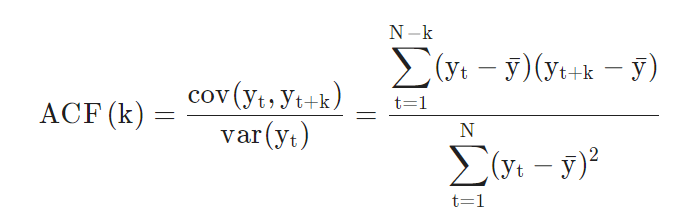

위의 식에서 분모인 분산 $var(y_t)$은 N개의 관측값을, 분자인 공분산 $cov(y_t,y_{t+k})$는 N−k개의 관측값을 계산해요. ACF plot에서는 유의미한 상관과 유의미하지 않은 상관을 확인할 수 있는데, 점선(유의 한계) 위쪽이 유의미한 값이고, 해당 시차에 대한 상관이 0이 아니라는 것을 의미해요.

**PACF** (편자기상관함수, Partial Autocorrelation Function)는 시점 t와 t−k 사이에 존재하는 t−1, t−2, ..., t−k+1의 영향을 제외하고 구한 자기상관값이에요. ACF를 사용해 모든 시계열 데이터를 분석하기에는 한계가 있기 때문에 PACF를 사용한 추가적인 분석이 필요해요. 수식은 아래와 같아요.

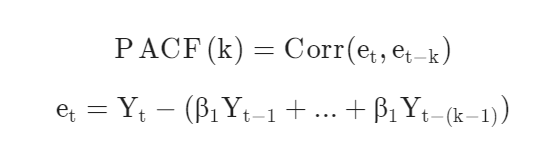

$e_t$는 $y_{t−k}$를 제외하고 $y_{t−1}$에서 $y_{t−(k−1)}$로 설명될 부분을 제거한 것이기 때문에 PACF는 온전히 $y_t$와 $y_{t−k}$의 관계만 볼 수 있어요. PACF plot에서도 점선(유의 한계) 위쪽이 유의미한 값이에요.

**ACF나 PACF가 특정한 주기로 크거나 작은 값을 가진다면 계절성을 의심** 할 수 있어요. ACF, PACF plot을 그려서 데이터에 특정 주기가 있는지 확인해 봅시다.

In [ ]:
# ACF, PACF plot
plot_acf(time_series_op_rate_replace)
plot_pacf(time_series_op_rate_replace)
plt.show()

ACF, PACF plot에서 **주기 7의 강한 계절성** 을 관측할 수 있어요. 이제 `lag = 7`로 차분을 실시하고 다시 ACF와 PACF를 확인해 봅시다.

In [ ]:
# 차분 
time_series_op_rate_diff = time_series_op_rate_replace.diff(7).dropna()
plot_acf(time_series_op_rate_diff)
plot_pacf(time_series_op_rate_diff)
plt.show()

계절 차분을 한 이후에도 계절성이 남아있지만, 처음에 비해선 일부 제거된 모습이군요.

ADF 검정(Augmented Dickey-Fuller Test)
시계열 데이터가 정상적(stationary)인지를 판단하기 위해서 ADF 검정(Augmented Dickey-Fuller Test) 을 할 수 있어요.

ADF 검정은 정상성을 알아보기 위한 단위근 검정 방법이에요. 참고로 단위근(unit root)이란 $x=1, y=1$인 해로, 시계열 자료에서 예측할 수 없는 결과를 가져올 수 있어요.

검정에는 자료에 단위근이 존재한다는 귀무가설(Null Hyperthesis, $H_0: \alpha = 1$)과 자료에 단위근이 존재하지 않아 시계열 자료가 정상성을 만족한다는 대립가설(Alternative Hypothesis, $H_1: \alpha / 1$), 이렇게 2가지 가설을 사용하고, 검정을 통해 귀무가설을 기각하면 정상성을 띤다고 볼 수 있어요.

조금 더 자세히 설명하면, ADF 검정은 1979년 David Dickey와 Wayne Fuller에 의해 개발된 DF 검정을 일반화한 검정이에요. Dickey-Fuller 단위근 검정은 단위근이 존재한다는 귀무가설을 통계적으로 검정하는 방법이에요.
$$
y_t=c+βt+αy_{t−1}+ϕ∇y_{t−1}+e_t
​$$
 
위의 식에서 cc는 시계열 데이터의 레벨, \betaβ는 시계열 데이터의 추세항이에요. 각 파라미터를 regression으로 추정해 \alphaα가 단위근을 가질 확률을 검정합니다. \alpha=1α=1이면 단위근을 가지는 것이기 때문에 정상성을 띠지 않는다고 판단해요.

ADF 검정은 DF 검정에 p lag의 차분을 추가해 검정 능력을 더 강화시켰습니다. 식은 아래와 같아요.

$$
y_t=c+βt+αy_{t−1}+ϕ_1∇y_{t−1}+...+ϕ_p∇y_{t−p}+e_t
​$$​
 
DF 검정의 식에서 p lag의 차분만큼 항이 추가된 것을 알 수 있죠? t-pt−p 시점까지의 차분 경향성을 파악할 수 있어서 주기를 가진 데이터의 정상성 여부를 판단할 수 있어요.

ADF 검정의 귀무가설은 DF 검정과 귀무가설이 같으므로 **검정통계량이 Critical Value보다 작거나 p-value가 설정한 유의수준 값보다 작으면 정상적**인 시계열 데이터라고 볼 수 있어요.

In [ ]:
p_value = adfuller(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars)[1]
print(f'p-value of ADF test (diff 7): {p_value}')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

plt.plot(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars);

plt.show()

ADF 검정 결과, 단위근이 있다는 귀무가설이 유의수준 0.05에서 기각되었어요. 이는 **시계열이 정상성을 가지고 있다** 는 증거이기 때문에 추가적인 차분이나 로그변환을 진행하지는 않을 거예요.

더 짧은 기간을 그려서 계절성이 제거되었는지 볼게요.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

plt.plot(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars[0:100], "b.-")

plt.show()

계절 차분 이후 계절성이 제거된 모습을 확인할 수 있었어요.

### 모형 적합과 검증

___

이제부터 ARIMA 모형을 적합시켜 보겠습니다. 우선 학습 데이터와 테스트 데이터로 2021년 4월 1일을 기준으로 분리할게요. 계절차분을 1번 해주었기 때문에 $d=1$이에요. ACF, PACF plot을 참고로 하여 모수 $p=3$, $q=1$를 가지는 ARIMA 모형을 적합시켜보겠습니다.

In [ ]:
# Split Train/Test data
op_rate_train = time_series_op_rate_diff[time_series_op_rate_diff.index<'2021-04-01']
op_rate_test = time_series_op_rate_diff[time_series_op_rate_diff.index>='2021-04-01']

model = ARIMA(op_rate_train, order=(3, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

학습 데이터에 대해 ARIMA 모형이 잘 fit하는지 시각화해보겠습니다.

In [ ]:
fitted_m.plot_predict()
plt.show()

`forecast()`를 이용해 테스트 데이터 구간의 데이터를 예측해 하고, RMSE를 구해 봅니다.

In [ ]:
fc, se, conf = fitted_m.forecast(len(op_rate_test), alpha=0.05)  # 95% conf

arima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(op_rate_test, fc))
print(f'Test RMSE: {arima_rmse}\n')

# Make as pandas series
fc_series = pd.Series(fc, index=op_rate_test.index)   # 예측결과


# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

plt.plot(op_rate_train, alpha=0.5, color='black', label='training')
plt.plot(op_rate_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(fc_series, alpha=0.5, color='blue', label='predicted operation rate')
plt.legend()

plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=30.0) 
ax.xaxis.set_major_locator(loc)

plt.show()

지금까지 ARIMA 모형을 적합해 차량 수요 예측을 해 보았어요. 그런데 ARIMA 모형을 통해 차량 수요 예측이 잘 되었다고 할 수 있을까요?

다음 스텝에서는 SARIMA 모형에 대해 배워볼 것입니다. 또한 계절성을 제거하기 전의 데이터를 가지고 SARIMA 모형을 적합한 뒤, 차량 수요 예측을 수행하여 ARIMA 모형의 예측 정확도와 비교해 보겠습니다.

## 2-4. SARIMA 모형을 활용한 차량 수요 예측

이번에는 SARIMA 모형을 사용해 차량 수요 예측을 하려고 합니다. 이전 스텝에서 계절성과 정상성을 점검하고, 차분과 로그 변환을 했기 때문에 모형 판별과 적합을 한 뒤 모형이 적절했는지 점검하는 과정을 진행할 것입니다. ARIMA 모형과는 달리 SARIMA 모형에서는 `auto_arima()`를 사용해 AIC를 최소로 하는 모델을 자동으로 찾을 거에요.

### SARIMA 모형

___

**SARIMA** (Seasonal Autoregressive Integrated Moving Average) 모형은 **ARIMA 모형(p, d, q)에 계절적 주기 S(Seasonal)를 기준으로 하는 AR, I, MA를 추가해 예측** 하는 모형이에요. 일종의 이중적인 ARIMA 모형인 셈이죠. 계절적 주기가 들어갔기 때문에 계절성 ARIMA 모형이라고 부르기도 해요. 참고로 ARIMA(p, d, q)와 SARIMA(p, d, q)(0, 1, 0, 0)은 동일한 모형이에요.

**계절성은 특정 패턴이 주기적** 으로 나타나요. 이 주기적인 특성을 AR 모형이나 MA 모형만을 사용해 나타내는 것은 어렵지만, SARIMA 모형을 사용하면 쉽게 다룰 수 있어요. SARIMA 모형의 일반적인 모형은 아래와 같아요. 표현되는 항의 수가 많아서 후방이동 연산자 B(Backshift Operator)를 활용해서 간단히 표현해요.

$$
ΦP(B^S)ϕ_p(B)(1−B^S)^D(1−B)^dy_t=ΘQ(B^S)θ_q(B)a_t
$$

>참고로 후방이동 연산자는 시계열 시차를 다룰 때 유용한 표기법이고, 아래와 같아요.
$$
By_t = y_{t-1}
$$
$yt$에 작용하는 후방이동 연산자 B는 데이터를 한 시점 뒤로 옮겨줘요. 예를 들어 월별 데이터에서 '지난해 같은 달'을 표현하고 싶으면,
$B^{12}y_t = y_{t-12}$로 표기해요. 또한 d차 차분은 $(1-B)^dy_t$로 표기합니다.
>
위 모형은 SARIMA(p, d, q)(P, D, Q, S)이며, 비계절성 부분 (p, d, q)와 계절성 부분 (P, D, Q, S)로 구분할 수 있어요. 여기서 p는 비계절성 AR 모형 차수, d는 비계절성 차분 횟수, q는 비계절성 MA 모형 차수, P는 계절성 AR 모형 차수, D는 계절성 차분 횟수, Q는 계절성 MA 모형 차수, S는 주기의 길이를 의미해요. 식에서 보듯 추자적인 계절성 항을 비계절성 항에 곱해주는 거에요.

예를 들어 설명해 볼게요. SARIMA(1,0,0)(1,0,0,12)의 경우, 각 달은 한 달 전의 값과 12달 전의 값에 영향을 받는다고 생각할 수 있어요. 2021년 9월의 값은 2021년 8월의 값과 2020년 9월의 값의 선형 회귀라고 볼 수 있어요.

$$
2021년 9월의 값 = (2021년 8월의 값) * 계수1 + (2020년 9월의 값) * 계수2 + 오차항
$$

위와 같이 식을 세우고 계수1과 계수2를 추정해 나가면서 AIC 등의 적합도와 예측능력을 통해서 모델의 형태를 바꿔나갈 수 있어요.

SARIMA 모형을 선택하는 기준은 AIC 등의 적합도와 모형 복잡도 패널티를 종합해 선택하거나 검증 데이터에 대해 모형의 예측 능력을 결정해요.

### 모델 판별 및 적합

___

이제부터 `auto_arima()`를 이용해 **Multiplicative SARIMA 모형** 을 적합해 봅시다. `auto_arima()`는 AIC를 최소로 하는 모델을 자동으로 찾아줘요. 참고로 AIC(Akaike Information Criterion)는 주어진 데이터셋에 대한 통계 모델의 상대적인 품질을 평가하는데, AIC 값이 낮을수록 모델의 적합도가 높다는 것을 의미해요. AIC의 공식은 아래와 같아요.

$$
AIC = -2\ln(L) + 2k
$$

$-2\ln(L)$은 모형의 적합도이고, $L$은 Likelihood function이에요. $k$는 모형의 추정된 파라미터의 개수이며, 모형에 패널티를 주기 위해 사용해요. 어떤 모형이 적합도를 높이려고 불필요한 파라미터를 사용할 수도 있는데, 이를 상쇄시키려고 불필요한 파라미터가 증가할수록 $2k$만큼의 패널티를 주어 모델의 품질을 평가해요.

우선 2021년 4월 1일을 기준으로 학습데이터와 테스트 데이터를 나눈 후, `auto_arima()`를 사용해 모형을 결정해봅시다. 우리는 SARIMA 모형을 사용하므로 계절차분을 하지 않은 데이터를 사용한다는 점을 유의하세요.

stepwise search를 하는 데에 3~6분 정도 소요된다는 점을 유의하세요!

In [ ]:
model_auto_arima = pm.auto_arima(op_rate_train, seasonal=True, m=7, D=1)
print('슝~')

In [ ]:
print(model_auto_arima)
print(model_auto_arima.params())
print(model_auto_arima.aic())

가장 적절한 모델이 결정되었어요. 모델이 찾아낸 파라미터들이 보이나요?

Q3. 가장 적절한 SARIMA 모형은 무엇인가요? 각 파라미터의 의미는 무엇인가요?

예시답안

ARIMA(p, d, q)(P, D, Q)\[S\] = SARIMA(p, d, q)(P, D, Q, S). p는 비계절성 AR 모형 차수, d는 비계절성 차분 횟수, q는 비계절성 MA 모형 차수, P는 계절성 AR 모형 차수, D는 계절성 차분 횟수, Q는 계절성 MA 모형 차수, S는 주기의 길이이다.

### 모델 점검

___

적당한 모델을 찾았으니 모델을 점검해 봅시다. 먼저 예측 결과를 확인해 이상이 있는지 확인해 볼게요. 예측 결과가 특별히 예상되는 범위를 벗어나는지, 혹은 도메인 지식과 어긋나는 패턴을 보이진 않는지 확인해 보세요.

In [ ]:
op_rate_pred, conf_int = model_auto_arima.predict(n_periods=op_rate_test.shape[0], return_conf_int=True)
sarima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(op_rate_test, op_rate_pred))
print(f'Test RMSE: {sarima_rmse}\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(op_rate_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(op_rate_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(op_rate_test.index.values, op_rate_pred, alpha=0.5, color='blue', label='predicted operation rate')
plt.fill_between(op_rate_test.index.values, conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b') # Confidence Interval
plt.legend()
plt.show()

수치와 시각화를 통해 `auto_arima()`를 통해 결정된 SARIMA 모형이 차량 수요 예측을 잘하는지 살펴보았어요. 그래프를 통해 보니 실제값과 예측값이 조금 차이 나는 것 같죠? 이전에 사용했던 ARIMA 모형과 비교해도 예측 정확도가 낮아요.

마지막으로 `plot_diagnostics()` 을 이용해 잔차에 대한 검증을 해봅시다. 잔차에 자기상관이 남아있으면 모델이 적절치 않았을 수 있다는 의미입니다. 왜냐하면 애초에 시계열분석이 자기상관성을 파악하기 위한 것이기 때문에, 잔차에 아직 독립성이 결여되어있다면 분석이 덜 된 것으로 볼 수 있기 때문입니다.

In [ ]:
model_auto_arima.plot_diagnostics(figsize=(10, 10))
plt.show()

위의 그래프는 아래와 같이 분석할 수 있어요.

-   Standardized residual: 일부의 잔차가 이상치로 확인되고 있어요.
-   Histogram plus estimated density: 잔차가 정규분포를 따르지 않는 것으로 보여요. KDE라인이 N(0, 1) 라인에 비해 뾰족하죠?
-   Normal Q-Q plot: 잔차의 분포(파란 선)가 양 끝에서 정규분포를 크게 벗어나는 잔차가 많기 때문에 정규성을 띠지 않아요. (잔차의 분포가 정규성을 띠는지, 아닌지가 애매하면 shapiro-wilk test같은 정규성 검정을 사용하세요.)
-   Correlogram(자기상관도): 잔차의 자기상관성이 관측되지 않으므로 기존의 계절성을 모델이 효과적으로 해결했다고 볼 수 있어요.

## 2-5. 여러 머신러닝 모델을 활용한 차량 수요 예측

이번에는 ARIMA 모델의 예측과 정확도를 비교하기 위해 시계열 자료의 패턴을 이용하지 않은 선형 회귀 분석과 회귀계수 축소법을 사용하겠습니다. 선형 회귀 분석은 이전에도 했었죠? 이번에는 RMSE를 사용하여 모형의 성능을 판단해 보려고 해요.

회귀계수 축소법은 데이터의 과적합 문제를 해결하기 위한 정규화 방법 중 하나인데요, 여기서는 Ridge와 Lasso를 사용할 예정입니다.

### 선형 회귀 분석

___

먼저 선형 회귀 분석을 해볼게요. 설명 변수로 존 클릭 수, 날씨, 요일을 넣어주고, `target_dates`를 인덱스로 정합니다. 데이터셋을 2021년 4월 21일을 기준으로 학습 데이터와 테스트 데이터로 나눈 후, OLS 선형회귀 검정을 수행해 봅시다.

In [ ]:
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

_x_data.set_index("target_dates", drop=True, inplace=True)
_x_data = _x_data.sort_values('target_dates')

# 예측 대상 데이터 설정
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]

target.set_index("target_dates", drop=True, inplace=True)
target = target.sort_values('target_dates')

# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']

# 상수항 추가
x_data_train = sm.add_constant(_x_data_train, has_constant='add')
x_data_test = sm.add_constant(_x_data_test, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target_train, x_data_train)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

$R^2=0.769$이므로 존 클릭 수, 날씨, 요일이 약 77% 정도 가동률을 설명하고 있어요. 이제 회귀모델을 평가해보겠습니다.

In [ ]:
ols_pred_test = model_fit.predict(x_data_test)
linreg_rmse = np.sqrt(sklearn.metrics.mean_squared_error(target_test, ols_pred_test))
print(f'Test RMSE: {linreg_rmse}')

선형 회귀의 평가는 실제값과 회귀 예측값의 차이를 기반으로 하는데요, 여기서는 RMSE를 사용했어요. RMSE가 0.0234이니 예측값과 실제값의 차이가 크지 않다는 거겠죠?

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, ols_pred_test, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

시각화를 통해서도 예측값인 파란색 실선과 실제값인 빨간색 실선이 비슷한 패턴으로 변하는 것을 볼 수 있어요.

### 정규화 - 회귀계수 축소법

___

이번에는 Ridge와 Lasso를 이용한 회귀계수 축소 방법을 사용해 봅시다. **회귀계수 축소법** 은 회귀계수를 축소하는 항(패널티)를 추가하는 방법인데요, 회귀계수를 축소하면 과적합(overfitting) 문제를 해결할 수 있고, 잡음(noise)이 제거되어 모형의 정확도가 개선돼요. 중요한 변수만 남기 때문에 모형의 연산 속도도 빨라져요.

회귀계수 축소법에는 축소하는 항이 어떤 것인지에 따라 3가지 방법이 있지만 우리는 Ridge와 Lasso를 이용할 거에요. Ridge와 Lasso에 대해 들어본 적이 있나요? L1, L2 정규화는 들어본 적이 있을 겁니다. Ridge와 Lasso는 간단하게 L1, L2 정규화를 선형 회귀 모형에 사용한 거에요. 선형 회귀 모형에 L1 정규화를 하면 Lasso, L2 정규화를 하면 Ridge가 되는 거죠. 참고로 L1, L2 정규화를 모두 적용한 것이 Elastic-Net이에요.

Ridge와 Lasso의 식은 아래와 같아요. 식에서 λ가 붙은 부분이 L1, L2 정규화 부분이랍니다. 참고로 λ는 하이퍼파라미터에요. 우리가 앞으로 사용할 라이브러리에서는 λ 대신 α를 하이퍼파라미터로 사용하고 있다는 점을 유의하세요.

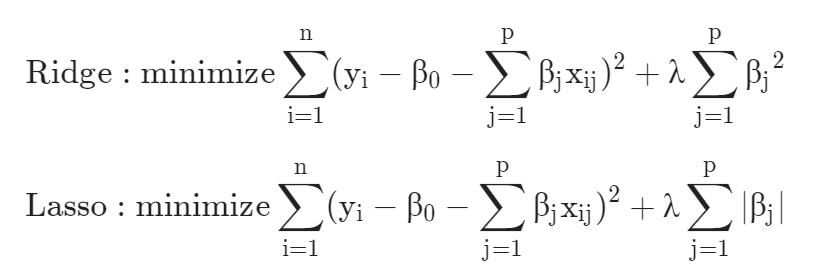

회귀계수 축소법에 대해 자세히 알고 싶다면 아래의 자료를 참고하세요.

-   [회귀계수 축소법 - Lasso, Ridge, Elastic-Net 개념](https://todayisbetterthanyesterday.tistory.com/12)

**Ridge**  
먼저 가장 적당한 alpha 값(λ)을 구해 볼게요.

In [ ]:
x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test

print("슝~")

In [ ]:
alpha_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ridge_op_rate_cv = RidgeCV(alphas=alpha_values, cv=5).fit(x_train, y_train.values.ravel())

print(ridge_op_rate_cv.alpha_)

가장 적당한 alpha 값이 1.0으로 나오네요. (참고로, 가장 적당한 alpha 값은 변동될 수 있어요.) 이제 모델 훈련과 예측을 하여 RMSE를 구해 봅시다.

In [ ]:
ridge_op_rate = Ridge(alpha=1).fit(x_train, y_train)
y_pred_ridge = ridge_op_rate.predict(x_test)
ridge_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_ridge))
print(f'Test RMSE: {ridge_rmse: .5f}')

Ridge를 이용해도 RMSE의 값이 기본 선형회귀 분석과 별 차이가 안 나네요. 시각화를 해서 예측을 잘 하고 있는지 확인해 봅시다.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, y_pred_ridge, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

어떤가요? 이제 Lasso에 대해서 동일한 과정을 적용해 봅시다.

**Lasso**

In [ ]:
alpha_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lasso_op_rate_cv = LassoCV(alphas=alpha_values, cv=5).fit(x_train, y_train)
print(lasso_op_rate_cv.alpha_)

In [ ]:
lasso_op_rate = Lasso(alpha=0.0005).fit(x_train, y_train)
y_pred_lasso = lasso_op_rate.predict(x_test)
lasso_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_lasso))
print(f'Test RMSE: {lasso_rmse}')

가장 적절한 alpha 값은 0.0001이고, RMSE는 기본선형회귀분석이나 Ridge보다 조금 높아요. 시각화를 해 봅시다.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)


plt.plot(target_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, y_pred_lasso, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

선형 회귀에서 파생된 모델의 경우, feature의 개수가 그렇게 많지 않았기 때문에 정규화가 큰 효과를 발휘하지 못했음을 확인할 수 있었어요.

## 2-6. 수요 예측 모델의 성능 개선

이번 스텝에서는 데이터 정제를 통해 성능을 개선해보려고 해요. 보통 데이터 정제는 EDA 과정에서 하지만 성능 개선을 위해 데이터 정제를 하는 이유는 데이터 정제를 통한 모델링의 효과를 보기 위해서에요. 데이터 정제를 통해 얼마나 성능이 개선되는지 확인해 봅시다.

데이터 정제 방법에는 여러 가지가 있지만 이번에는 간단히 **이상치(outliers) 제거** 를 해보겠습니다.

### 이상치 확인

___

이상치는 대부분의 값의 범위에서 벗어나 극단적으로 작거나 큰 값이에요. 이상치는 빈도는 작지만 영향력이 크기 때문에 데이터에 이상치가 있으면 정확한 분석을 하기 어려워요. 먼저 산점도와 박스 플롯을 그려 이상치가 존재하는지를 확인해 봅시다.

**산점도**

산점도에는 어떤 패턴이 있는데, 그 패턴에서 벗어나는 값을 이상치라고 할 수 있어요. 아래의 산점도에서 특정 패턴을 벗어난 이상치가 있는지 살펴 봅시다. 먼저 `df_raws` 데이터에서 필요 없는 컬럼을 제거하고, 산점도를 그립니다.

In [ ]:
columns = df_raws.columns.tolist()
columns.remove('target_dates')
columns.remove('op_rate_0d_all_cars')
columns.remove('op_rate_0d_major_cars')
columns.remove('op_rate_1d_major_cars')
columns.remove('op_rate_2d_major_cars')
columns.remove('op_rate_3d_major_cars')
columns.remove('op_rate_4d_major_cars')
columns.remove('op_rate_5d_major_cars')
columns.remove('op_rate_6d_major_cars')
columns.remove('op_rate_7d_major_cars')

fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(10, 70))

for i, temp_column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.scatterplot(
        ax=axs[row, col],
        data=df_raws,
        x='op_rate_0d_all_cars',
        y=f'{temp_column}',	
    ).set_title(f'{temp_column}', fontsize=10)

plt.show()

**박스플롯**

이번에는 박스플롯을 그려서 이상치가 존재하는지 확인해 보죠. 아래의 그림에서처럼 수염(whiskers)보다 바깥쪽에 존재하는 데이터가 이상치에요.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/outliers.max-800x600.png)

\[박스플롯과 이상치\]

[https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

In [ ]:
fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(10, 70))

for i, temp_column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.boxplot(
        ax=axs[row, col],
        data=df_raws[f'{temp_column}']	
    ).set_title(f'{temp_column}', fontsize=10)

plt.show()

n일 전 사전 가동률과 n일 전 클릭 수, 평균 강수량 등에서 이상치를 발견할 수 있어요.

#### 이상치 제거

___

이제 발견한 이상치를 없애면 될까요? 이상치를 무조건 제거하기 보다 이상치가 어떤 값인지 먼저 살펴보아야 해요. 오타나 오류라면 제거해도 되지만 데이터가 작거나 이상치가 중요한 값인 경우에는 평균, 중앙값 등으로 치환하거나 이상치를 따로 분리를 해서 분석하는 등 다른 방법을 생각해 봐야 해요.

하지만 여기서는 간단히 이상치를 제거하는 방법을 사용해 보려고 해요. 이상치 제거 함수를 만들어서 이상치를 제거해 봅시다. 사분위범위수(IQR, Interquartile range)를 이용해 이상치 제거 함수를 만들 수 있어요.

In [ ]:
df_clean = df_raws.copy()

# 이상치 제거 함수
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR * weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][(df[column]<lowest) | (df[column]>highest)].index
  return outlier_idx

print("쓩~")

In [ ]:
outlier_idx_click_d_1 = get_outlier(df=df_clean, column='click_d_1', weight=1.5).tolist()
outlier_idx_click_d_2 = get_outlier(df=df_clean, column='click_d_2', weight=1.5).tolist()
outlier_idx_click_d_3 = get_outlier(df=df_clean, column='click_d_3', weight=1.5).tolist()
outlier_idx_click_d_4 = get_outlier(df=df_clean, column='click_d_4', weight=1.5).tolist()
outlier_idx_click_d_5 = get_outlier(df=df_clean, column='click_d_5', weight=1.5).tolist()
outlier_idx_click_d_6 = get_outlier(df=df_clean, column='click_d_6', weight=1.5).tolist()
outlier_idx_click_d_7 = get_outlier(df=df_clean, column='click_d_7', weight=1.5).tolist()
outlier_idx_avg_precipitation = get_outlier(df=df_clean, column='avg_precipitation', weight=1.5).tolist()

print("쓩~")

설명 변수 컬럼의 이상치의 인덱스를 합치고, 중복된 인덱스를 제거해 이상치가 총 몇 개가 있는지 살펴봅시다.

In [ ]:
# 각 컬럼 outlier index 합치기
outlier_idx = outlier_idx_click_d_1 + outlier_idx_click_d_2 + outlier_idx_click_d_3 + outlier_idx_click_d_4 + outlier_idx_click_d_5 + outlier_idx_click_d_6 + outlier_idx_click_d_7 + outlier_idx_avg_precipitation 


# outlier index 중복 제거
outlier_idx_set = set(outlier_idx)
outlier_idx = list(outlier_idx_set)

len(outlier_idx)

이상치 제거 후와 비교하기 위해서 제거 전의 정보를 확인해 볼게요.

In [ ]:
df_clean.info()

In [ ]:
df_clean.head(10)

준비가 끝났으니 이제 이상치를 제거하고, 데이터를 다시 확인해 보죠.

In [ ]:
df_clean.drop(outlier_idx, axis=0, inplace=True)

df_clean.info()

In [ ]:
df_clean.head(10)

### 정제된 데이터로 재 모델링 해 보기

___

이상치를 제거하여 정제된 데이터로 재모델링해 봅시다. 이전과 같이 선형회귀와 Ridge/Lasso를 이용한 계수축소법을 사용할 거에요.

**선형회귀**

In [ ]:
# 설명 변수 테이블 설정
_x_data_clean = df_clean[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday_clean = pd.get_dummies(df_clean['weekday'], prefix='weekday', drop_first=False)

_x_data_clean = pd.concat([_x_data_clean, _x_weekday_clean], axis=1)

_x_data_clean.set_index("target_dates", drop=True, inplace=True)
_x_data_clean = _x_data_clean.sort_values('target_dates')

# 예측 대상 데이터 설정
target_clean = df_clean[['op_rate_0d_all_cars', 'target_dates']]

target_clean.set_index("target_dates", drop=True, inplace=True)
target_clean = target_clean.sort_values('target_dates')

# Train/Test 데이터셋 나누기
_x_data_train_clean = _x_data_clean[_x_data_clean.index<'2021-04-01']
_x_data_test_clean = _x_data_clean[_x_data_clean.index>='2021-04-01']
target_train_clean = target_clean[target_clean.index<'2021-04-01']
target_test_clean = target_clean[target_clean.index>='2021-04-01']

# 상수항 추가
x_data_train_clean = sm.add_constant(_x_data_train_clean, has_constant='add')
x_data_test_clean = sm.add_constant(_x_data_test_clean, has_constant='add')

# OLS 선형회귀 검정
model_clean = sm.OLS(target_train_clean, x_data_train_clean)
model_clean_fit = model_clean.fit()

# 결과물 출력
print(model_clean_fit.summary())

In [ ]:
ols_pred_test_clean = model_clean_fit.predict(x_data_test_clean)
linreg_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(target_test_clean, ols_pred_test_clean))
  
print(f'.    Test RMSE: {linreg_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {linreg_rmse: .5f}')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, ols_pred_test_clean, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

### Ridge

In [ ]:
x_train = _x_data_train_clean
x_test = _x_data_test_clean
y_train = target_train_clean
y_test = target_test_clean

alpha_values_clean = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ridge_op_rate_cv_clean = RidgeCV(alphas=alpha_values_clean, cv=5).fit(x_train, y_train.values.ravel())

print(ridge_op_rate_cv_clean.alpha_)

In [ ]:
ridge_op_rate = Ridge(alpha=1).fit(x_train, y_train)
y_pred_ridge = ridge_op_rate.predict(x_test)
ridge_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_ridge))
print(f'.    Test RMSE_cleaned:      {ridge_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {ridge_rmse: .5f}\n\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)


plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, y_pred_ridge, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

### Lasso

In [ ]:
alpha_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lasso_op_rate_cv = LassoCV(alphas=alpha_values, cv=5).fit(x_train, y_train.values.ravel())

print(lasso_op_rate_cv.alpha_)

In [ ]:
lasso_op_rate = Lasso(alpha=0.0005).fit(x_train, y_train)
y_pred_lasso = lasso_op_rate.predict(x_test)
lasso_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_lasso))
print(f'     Test RMSE:              {lasso_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {lasso_rmse: .5f}\n\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, y_pred_lasso, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

Q4. 데이터 정제 전과 정제 후의 모델링의 결과를 비교해 보세요.

예시답안

이상치 제거를 통한 데이터 정제 후의 모든 회귀 모형의 RMSE의 값이 감소하는 것으로 보아 데이터 정제 후 성능이 개선되었음을 알 수 있다.

이상치를 제거하고 모델링을 하면 성능(RMSE 등) 개선 효과는 있어요. 하지만 우리가 다루고 있는 시계열 데이터에서는 빈틈이 생기면 안 되기 때문에 선형 보간법 등으로 해당 이상치를 다른 값으로 대체해 주는 것이 좋아요. 위와 같이 이상치를 제거하고 시계열 데이터를 다룬다면 소용이 없답니다. 그렇다면 어떤 방법을 써야 좋은 결과를 얻을 수 있을까요? 다음 장에서 알아 봅시다.

## 2-7. 동적 회귀 모형의 이해

시계열 모형에는 시계열의 이전 관측값에서 얻은 정보는 들어가지만, 존 클릭 수, 날씨, 요일 등의 외부 변수들은 들어가지 않아요. 하지만 때로는 과거의 변동을 더 잘 설명할 수 있는 외부 변수가 더 정확하게 예측할 수도 있어요. 반대로 회귀 모형은 예측 변수(predictor variable)와 관련된 정보를 포함하지만 시계열을 다루기 어려워요.

'만약 시계열 데이터와 외부 변수를 모두 다룰 수 있다면 더 정확하게 예측할 수 있지 않을까?'라는 아이디어에서 만들어진 것이 **동적 회귀 모형(Regression with ARIMA error/Dynamic Regression Model)** 이에요. 쉽게 말하면 오차항에 ARIMA 구조를 가정한 모형이죠. 오차에 자기상관 구조가 존재하는 경우에 사용할 수 있어요.

회귀 모형의 식이 아래와 같다고 해보죠. $y_t$는 $k$ 예측변수 $(x_{1,t},...,x_{k,t})$의 선형 함수이고, $e_t$는 상관관계가 없는 오차항(백색잡음)이에요.

$$
y_t = β_0+β_1x_{1,t}+⋯+β_kx_{k,t}+ϵ_t
$$

동적 회귀 모형은 자기상관을 넣기 위해 회귀 모형에 $ϵ_t$ 대신 $η_t$을 넣어주고, $η_t$이 ARIMA 모형을 따른다고 가정해요. 만약 $η_t$가 ARIMA(1,1,1) 모형을 따르면 동적 회귀 모형은 아래와 같이 쓸 수 있어요. 참고로 아래의 식에서 $ϵ_t$는 백색잡음 시계열이에요.

$$
y_t=β_0+β_1x_{1,t}+⋯+β_kx_{k,t}+η_t
$$

$$
(1−ϕ_1B)(1−B)η_t=(1+θ_1B)ϵ_t
$$

동적 회귀 모형에는 두 개의 오차항, 즉 회귀 모형에서 온 오차$(η_t)$와 ARIMA 모형에서 온 오차$(ϵ_t)$가 있고, ARIMA 모형 오차만 백색잡음이랍니다.

-   [Chapter 9 동적 회귀 모델](https://otexts.com/fppkr/dynamic.html)

### SARIMAX

이제부터 동적 회귀 모형을 사용해 봅시다. `stats.model`의 SARIMAX를 사용할 것인데요, SARIMAX에서 X는 외부 변수인 eXogeneous를 의미해요. 즉 SARIMAX는 ARIMA 모형과 외부 변수를 합한 단어이고, 위에서 살펴 보았던 동적 회귀 모형을 생성해요.

SARIMAX의 주요 파라미터는 아래와 같아요. 자세한 내용은 [SARIMAX 공식 홈페이지](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html?highlight=sarimax%20parameter)를 확인해 보세요.

> -   endog : 관측된 시계열 데이터 (endogeneous)
> -   exog : 시계열 데이터에 영향을 미치는 외부 변수 데이터 (exogeneous)
> -   order : ARIMA의 (p, d, q), default는 (1, 0, 0)
> -   seasonal\_order : 계절성 부분인 (P, D, Q, S)

동적 회귀 모형을 모델링을 하기 위해서는 하이퍼파라미터 p, d, q, P, D, Q를 설정해 주어야 해요. 주기(S)의 경우에는 분기별 데이터일 경우에는 4, 월별 데이터의 경우에는 12로 설정해주죠. 우리가 예측하고자 하는 데이터의 주기는 7이므로 S=7로 설정해 주면 좋겠죠?

그 후 가장 낮은 AIC 값을 가지는 파라미터 조합을 선택하는데, 일반적으로 Grid search를 통해 해요.

차량 수요 예측을 하기 전에 다른 데이터를 사용해 간단한 동적 회귀 모형 실습을 해 봅시다. 아래의 코드는 [SARIMAX 공식 홈페이지](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)를 참고했어요.

먼저 데이터를 다운로드합니다.

In [ ]:
# Dataset
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
data = pd.read_stata(BytesIO(friedman2))
data.index = data.time
data.index.freq = "QS-OCT"

data.head()

데이터의 변수에는 m2, time, m1, consump, pc92가 있는데요, 각각의 의미는 아래와 같아요.

-   m2(광의통화): M1과 만기 2년 미만 정기 예/적금과 같이 약간의 이자만 포기하면 현금화할 수 있는 금융 상품을 포함합니다. MMF(머니마켓펀드), CD(양도성예금증서), CMA(종합자산관리계좌) 등의 시장형 금융상품, 금전신탁, 수익증권 등의 실적 배당형 금융상품, 금융, 종금사 발행어음 등도 포함됩니다.
-   m1(협의통화): 지폐, 동전, 요구불예금을 포함한 현금통화로, 언제든지 현금으로 전환될 수 있는 통화입니다.
-   consump: 개인 소비를 의미하며 단위는 '$'입니다. UAB 국민소득계정(NIPA)을 이용해 산출한 수치입니다.
-   pc92: 개인 소비를 의미합니다.

In [ ]:
data.info()

결측치를 확인해 보겠습니다.

In [ ]:
# 결측치 확인
data.isnull().sum()

In [ ]:
data[data['m1'].isnull()]

결측치는 m2, m1에 52개씩 존재하고, 1959년 이전의 데이터가 존재하지 않아요. 그러므로 1959년 이후의 데이터만 사용하겠습니다.

우리의 목적은 동적 회귀 모형을 사용해 보는 것이므로 EDA나 데이터 전처리는 생략하고 진행해보도록 할게요. 내부 변수이자 시계열 부분으로는 'consump', 외부 변수로는 'm2'를 설정해 보도록 하겠습니다. 파라미터인 orders는 임의로 설정해 보겠습니다.

In [ ]:
# Variables
endog = data.loc['1959':, 'consump']
exog = sm.add_constant(data.loc['1959':, 'm2'])
nobs = endog.shape[0]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
fit_res = mod.fit(disp=False, maxiter=250)
print(fit_res.summary())

모형이 잘 적합(fitting)되었는지 확인해 봅시다. 모형의 적합성은 아래의 것들로 판단할 수 있습니다.

-   Ljung-Box(L1)  
    시계열의 모형이 올바르게 적합되었는지 평가하는 시계열 모형 적합도 척도 중 하나입니다. 귀무가설은 '잔차가 white noise를 따른다'로 설정하고, p-value가 낮으면 시간대별 잔차가 상관(correlated)되어 있는 것으로 판단할 수 있어요.
    
-   Jarque-Bera  
    귀무가설을 '잔차가 normal distribution을 따른다'라고 가정하며, p-value가 낮으면 귀무가설을 기각해요.
    
-   Heteroskedasticity  
    각 시간대 별 잔차의 분산이 일정한지 보는 테스트에요. 귀무가설을 '잔차의 분산이 일정하다'라고 가정하며 p-value가 낮으면 귀무가설을 기각합니다.
    

Ljung-Box(L1)의 값은 작고, Jarque-Bera와 Heteroskedasticity의 값은 크므로 좋은 모형이 아닌 것 같아요.

`plot_diagnostic()`을 이용하여 잔차를 확인해 봅시다.

In [ ]:
fit_res.plot_diagnostics(figsize=(11, 8))
plt.show()

잔차의 분포를 나타낸 그래프도 위의 모형이 좋은 모형이 아니라는 것을 보여 주고 있어요. 히스토그램과 Q-Q 플롯을 보니 잔차가 정규성을 띠지 않는 것처럼 보여요. Correlogram에서도 잔차가 자기상관되는 것으로 보이는 군요.

하지만 파라미터를 조정하면 더 좋은 결과를 얻을 수 있을 거에요. 그래서 보통은 Grid search를 통해 최적의 파라미터를 찾아요. 하지만 지금은 위의 모형으로 진행하겠습니다.

이제 모형을 통해 예측을 해보고, 시각화를 통해 모형이 제대로 예측을 했는지 점검해 봅시다.

In [ ]:
pred = fit_res.get_prediction(dynamic='1978-01-01')
pred_ci = pred.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
data.loc['1977-07-01':, 'consump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions

pred.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = pred_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

시각화를 해 보니 시간이 흐를수록 예측을 잘 하고 있지 못함을 알 수 있어요. 그 이유는 파라미터를 임의로 설정한 것도 있겠죠? 다음 스텝인 프로젝트에서는 Grid search를 사용하여 더 좋은 모형을 찾을 수 있을 거에요.

## 2-8. 프로젝트: 어떤 예측 모형이 차량 수요 예측에 가장 적합할까?

이번 프로젝트에서는 이전 스텝에서 배운 동적 회귀 모형을 이용해 차량 수요 예측을 하고 그 결과를 다른 모형들과 비교하려고 합니다.

먼저 주요 라이브러리 버전을 살펴보죠.

In [ ]:
import pandas
import pmdarima
import statsmodels

print(pandas.__version__)
print(pmdarima.__version__)
print(statsmodels.__version__)

이제 아래의 스텝을 따라 프로젝트를 진행해 주세요.

### Step 1. 학습 데이터와 테스트 데이터 나누기

___

학습 데이터와 테스트 데이터는 '2-4. 여러 머신러닝 모형을 활용한 차량 수요 예측'에서 만들어 놓은 학습 데이터와 테스트 데이터를 그대로 사용하면 됩니다. 기억을 상기시키기 위해서 아래에 코드를 적어 놓았습니다.

```bash
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

_x_data.set_index("target_dates", drop=True, inplace=True)
_x_data = _x_data.sort_values('target_dates')

# 예측 대상 데이터 설정
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]

target.set_index("target_dates", drop=True, inplace=True)
target = target.sort_values('target_dates')

# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']
```

In [ ]:
x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test

### Step 2. Grid search를 이용하여 최상의 파라미터 조합 찾기

___

동적 회귀 모형을 선언하기 위해서는 (p, d, q) x (P, D, Q)(S) 파라미터를 설정해 주어야 합니다. 이 때 실제로 Grid search를 하여 가장 낮은 AIC를 가지는 파라미터 조합을 선택해요. Grid search는 파라미터가 가질 수 있는 선택지가 많아질수록 탐색 공간이 넓어져 탐색에 오랜 시간이 걸립니다. 예를 들어 모든 파라미터(p, d, q, P, D, Q 총 6가지)를 0과 2 사이(0 또는 1)에서 찾는다면, 탐색 공간은 26\=642^6=6426\=64개가 되고 5분 정도 걸려요.

itertools의 `product()`를 이용하여 최상의 파라미터 조합을 찾아 보세요. 아래 이미지와 같이 파라미터 조합이 나올 수 있도록 해보세요. 시간의 여유가 된다면 p, q, P, Q의 범위를 더 늘려 보세요.

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-09-07_10-53-01.png)

\[최상의 파라미터 조합과 AIC 탐색\]

In [ ]:
# 모수
p = range(0, 2)
q = range(0, 2)
d = range(0, 2)
P = range(0, 2)
Q = range(0, 2)
D = range(0, 2)

# 초기화
best_AIC = float("inf")
best_model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 7))
iter_cnt = 0

# for 문으로 최소 AIC 찾기 (Grid Search)

### YOUR CODE ###

### Step3. 모형 구조 확인

___

`model.summary()`를 사용해 모형의 정보를 출력해 보세요.

In [ ]:
# 모형 구조 확인

### YOUR CODE ###

### Step 4. 차량 수요 예측

___

예측값과 예측값의 신뢰구간을 얻을 수 있는 `get_forecast(steps=n)`을 사용해 보세요. 학습 데이터 다음부터 지정한 steps만큼 예측할 수 있어요. RMSE와 시각화를 통해 모형의 예측 정확도를 확인해 보세요. RMSE을 구할 때는 예측값에 `.predicted_mean`을 사용해보세요. 시각화할 때는 이전 스텝에서와 같이 마지막 50개의 데이터만 사용하세요.a|

In [ ]:
# RMSE

### YOUR CODE ###

In [ ]:
# 시각화

### YOUR CODE ###

### Step 5. 다른 모형 사용하기

___

지금까지 배운 모형이 아닌 다른 모형을 사용해 차량 수요 예측을 해보세요. 트리 기반 머신러닝 모형(LGBM, Gradient Boosting, XBG, Random Forest 등)을 사용해 보세요. 3개 이상의 모형을 사용해 차량의 수요를 예측해 보세요.

### Step 6. 결과 비교

___

동적 회귀 모형과 여러분들이 사용한 모형들의 예측 정확도를 RMSE를 사용하여 비교해 봅시다. 이전 스텝에서 다루었던 다른 모형들의 예측 정확도를 포함시켜도 좋아요. 어떤 모형이 차량 수요를 가장 잘 예측할까요?

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

| 평가문항 | 상세기준 |
| --- | --- |
| 
1\. 동적 회귀 모형을 사용하여 차량 수요 예측을 하였는가? | Grid search를 사용하여 최상의 파라미터 조합을 찾고, RMSE와 시각화를 통해 예측 정확도를 평가하였다. |
| 2\. 다양한 머신러닝 모형을 사용하여 차량 수요 예측을 하였는가? | 3개 이상의 머신러닝 모형을 사용하여 차량 수요 예측을 하였다. |
| 3\. 다양한 모형을 사용한 차량 수요 예측 결과를 비교, 분석하였는가?| 다양한 모형을 사용한 차량 수요 예측의 정확도를 RMSE를 사용하여 비교, 분석하였다. |